## Problema 3 Lista 3

En este problema analizaremos las acciones de 5 compañias tecnlógicas (Google, Microsoft, Apple, Intel y AMD) durante cinco años para intentar ver si se pueden hacer predicciones de los diferentes variables de nuestro df.

In [30]:
#! pip install scikit-optimize

In [71]:
import warnings
from sklearn import set_config 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.metrics import  ConfusionMatrixDisplay,\
                  classification_report,  RocCurveDisplay, \
                    accuracy_score, f1_score, precision_score, recall_score
                    
import matplotlib.pyplot as plt
                    
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from skopt import BayesSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPClassifier, MLPRegressor
from sklearn.metrics import confusion_matrix, roc_curve, auc


from numpy.lib.stride_tricks import sliding_window_view
from sklearn.preprocessing import MinMaxScaler, StandardScaler

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
from IPython.display import display, HTML
show_html = lambda html: display(HTML(html))

### Importación y primer análisis de los datos

In [32]:
import apafib
data = apafib.load_NASDAQ()
data.head()

,GOOGLE-P,GOOGLE-V,GOOGLE-GAP,MSFT-P,MSFT-V,MSFT-GAP,AAPL-P,AAPL-V,AAPL-GAP,INTEL-P,INTEL-V,INTEL-GAP,AMD-P,AMD-V,AMD-GAP
0,45.3330,18846560,0.4800,72.15,17698800,0.78,39.3025,105320280,0.6950,34.92,26479700,0.58,12.05,58786300,0.560
1,46.2345,23326400,0.7192,73.16,14333220,0.89,39.9450,86259560,0.4950,34.65,26093400,0.57,12.17,38946780,0.230
2,46.3500,21771500,0.5285,72.72,13758650,0.62,39.9950,77507760,0.3975,34.66,19775620,0.43,12.48,44193270,0.585
3,46.0640,25323820,0.7670,72.69,17097240,0.79,39.8175,79128680,0.5475,34.71,14283180,0.34,12.50,37161680,0.320
4,45.7945,21055280,0.5027,72.82,12790300,0.87,39.9650,100738400,0.3225,34.67,14714810,0.35,12.43,29650370,0.320


Como siempre, haremos una primera visualización de los datos

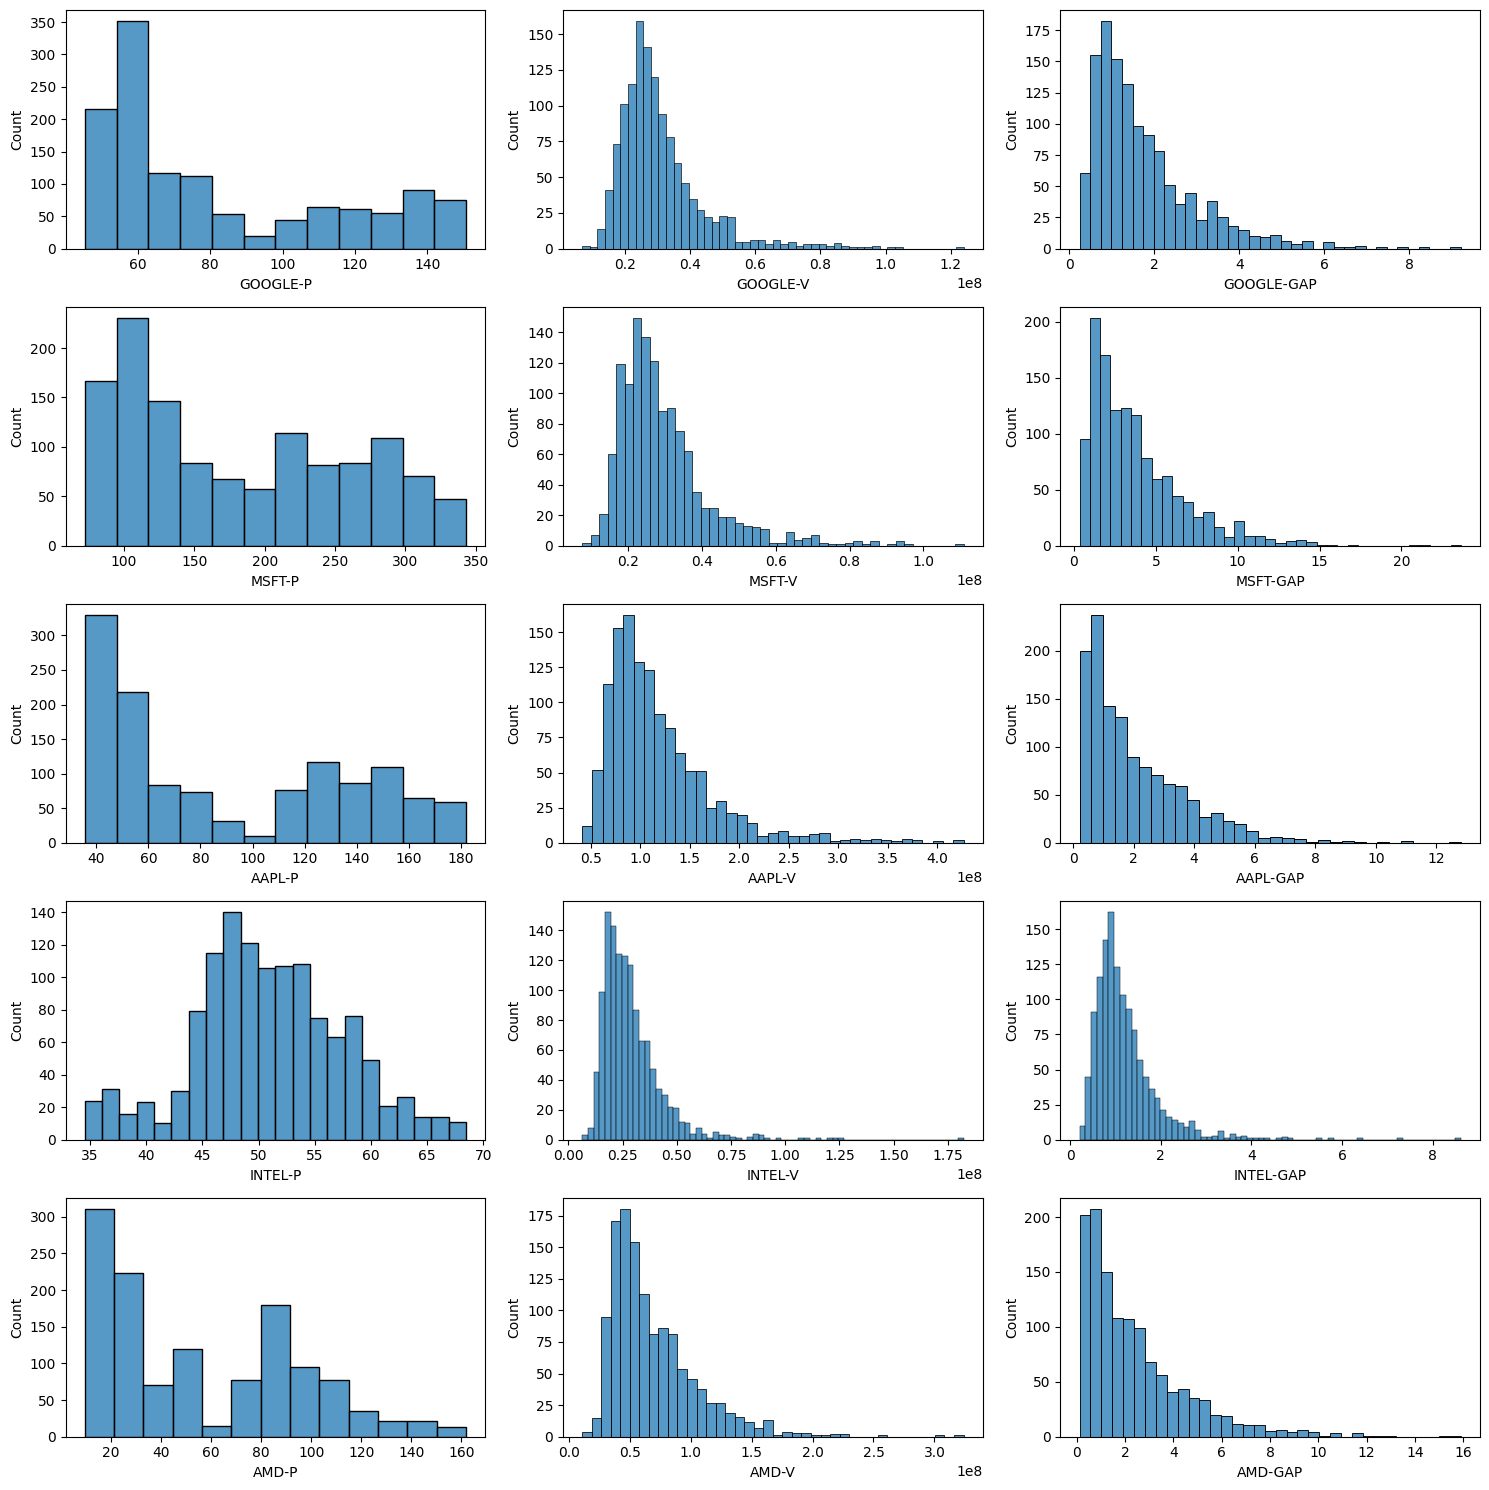

In [33]:
fig, axes = plt.subplots(5,3,figsize=(15,15))
for i, c in enumerate(data.columns[:15]):
    ax = axes.reshape(-1)[i]
    if data[c].dtype.kind == 'O':
        a = sns.countplot(x=c,data=data,ax=ax)
    else:
        b = sns.histplot(x=c,data=data,ax=ax)
plt.tight_layout()

Como vemos el volumen de intercambio de acciones en un dia es similar tanto en forma como en cantidad, en cambio podemos observar para las 3 variables de intel un comportamiento mas gaussiano. Aun asi, sin duda a primera vista vemos cierta relación entre todas.

Para enfocar el problema de una forma mas simple primeramente crearemos una variable objetivo para hacer un problema de clasificación la cual posteriormente nos ayudara a resolver el problema inicial. Esta variable indica si el valor de la acción subi respecto al dia anterior (0 no, 1 si).

In [34]:
columns = data.columns
data = data.to_numpy()
data_t = []
for day in range(len(data)):
    try:
        data_t.append(np.append(data[day],[bool(data[day][0] > data[day-1][0]), bool(data[day][1] > data[day-1][1])]))
    except IndexError:
        data_t.append(np.append(data[day],[False, False]))
data = pd.DataFrame(data_t,columns=[*columns, 'actionsValueIncreased', 'actionsCountIncreased'])
data.head()

,GOOGLE-P,GOOGLE-V,GOOGLE-GAP,MSFT-P,MSFT-V,MSFT-GAP,AAPL-P,AAPL-V,AAPL-GAP,INTEL-P,INTEL-V,INTEL-GAP,AMD-P,AMD-V,AMD-GAP,actionsValueIncreased,actionsCountIncreased
0,45.3330,18846560.0,0.4800,72.15,17698800.0,0.78,39.3025,105320280.0,0.6950,34.92,26479700.0,0.58,12.05,58786300.0,0.560,0.0,0.0
1,46.2345,23326400.0,0.7192,73.16,14333220.0,0.89,39.9450,86259560.0,0.4950,34.65,26093400.0,0.57,12.17,38946780.0,0.230,1.0,1.0
2,46.3500,21771500.0,0.5285,72.72,13758650.0,0.62,39.9950,77507760.0,0.3975,34.66,19775620.0,0.43,12.48,44193270.0,0.585,1.0,0.0
3,46.0640,25323820.0,0.7670,72.69,17097240.0,0.79,39.8175,79128680.0,0.5475,34.71,14283180.0,0.34,12.50,37161680.0,0.320,0.0,1.0
4,45.7945,21055280.0,0.5027,72.82,12790300.0,0.87,39.9650,100738400.0,0.3225,34.67,14714810.0,0.35,12.43,29650370.0,0.320,0.0,0.0


In [35]:
data.describe(include='all').T

,count,mean,std,min,25%,50%,75%,max
GOOGLE-P,1259.0,8.235332e+01,3.232053e+01,4.533300e+01,5.610350e+01,6.736500e+01,1.129415e+02,1.507090e+02
GOOGLE-V,1259.0,3.091715e+07,1.347789e+07,6.935060e+06,2.256946e+07,2.773012e+07,3.531136e+07,1.238938e+08
GOOGLE-GAP,1259.0,1.740178e+00,1.209965e+00,2.380000e-01,8.713000e-01,1.371000e+00,2.218750e+00,9.215500e+00
MSFT-P,1259.0,1.818206e+02,7.862105e+01,7.215000e+01,1.081500e+02,1.634900e+02,2.524850e+02,3.431100e+02
MSFT-V,1259.0,2.953929e+07,1.299424e+07,7.425603e+06,2.125149e+07,2.629290e+07,3.374066e+07,1.109450e+08
MSFT-GAP,1259.0,3.812815e+00,2.912805e+00,3.400000e-01,1.660000e+00,3.060000e+00,5.141250e+00,2.364000e+01
AAPL-P,1259.0,9.035068e+01,4.626909e+01,3.554750e+01,4.748250e+01,7.193250e+01,1.336400e+02,1.820100e+02
AAPL-V,1259.0,1.184749e+08,5.504025e+07,4.099995e+07,8.193916e+07,1.042700e+08,1.382814e+08,4.268848e+08
AAPL-GAP,1259.0,2.068242e+00,1.694044e+00,2.135000e-01,7.762500e-01,1.502500e+00,2.925000e+00,1.281000e+01
INTEL-P,1259.0,5.089460e+01,6.684044e+00,3.452000e+01,4.672000e+01,5.059000e+01,5.538000e+01,6.847000e+01


Ahora visualizaremos las correlaciones entre variables

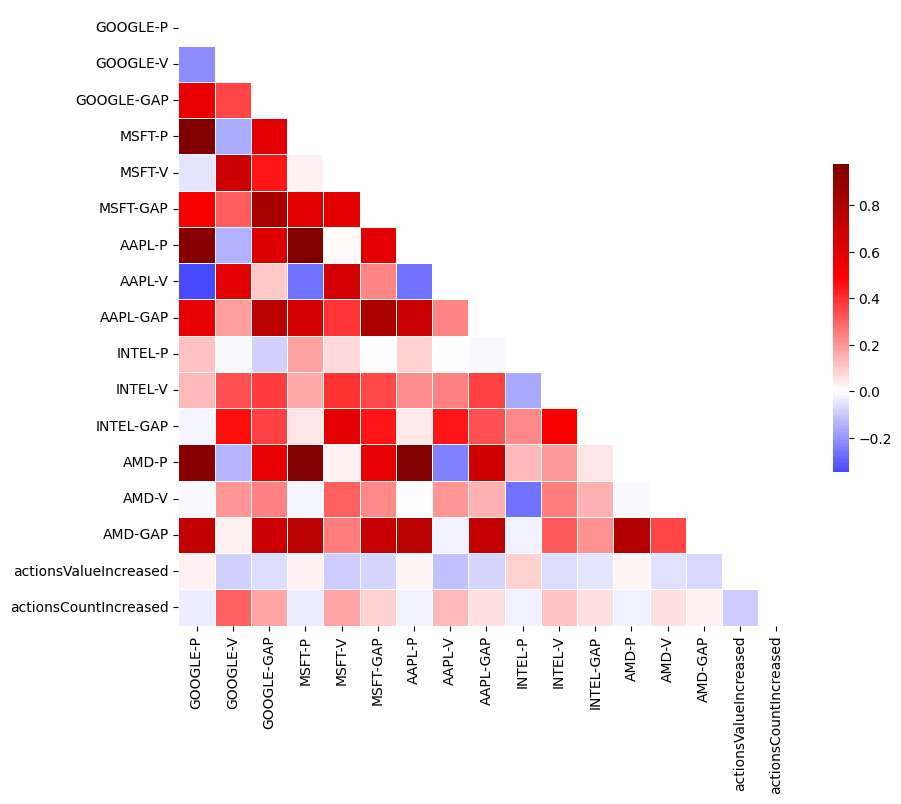

In [36]:
corr = data.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
plt.subplots(figsize=(10, 8))
sns.heatmap(corr, mask=mask, cmap='seismic',  center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5});

Como veiamos en la primera visualización todas las variables (sobretodo las del mismo tipo, es decir V,P o GAP) estan fuertemente relacionadas entre compañias

### Primer tratamiento de los datos
A diferencia de los problemas anteriores, en los cuales dividiamos el conjunto de forma aleatoria, dividiremos el conjunto de entrenamiento y test en los primeros 1000 dias seran los datos de entrenamiento y el resto seran de test.

In [37]:
s = 1000
data_train = data.iloc[:s]
data_test = data.iloc[s:]

Normalizamos los valores y los transformamos en un array de numpy para poder aplicar las transformaciones que se piden de una forma mas cómoda.


In [38]:
scaler = MinMaxScaler()
data_train_n = scaler.fit_transform(data_train.to_numpy())
data_test_n = scaler.transform(data_test.to_numpy())

Dividiremos los datos en ventanas de 3 dies, de forma que cada fila de datos, tenga información de 3 dies de los datos originales, mas les columnes que hemos añadido. A esta fila de datos, le corresponde una fila "objetivo" que corresponde a la variable objetivo del cuarto día. Para esto haremos uso de la función sliding_window_view que podemos aplicar directamente al tener el array de numpy

In [39]:
w = 3

windows_train = sliding_window_view(data_train_n, w+1, axis=0).copy()
windows_test = sliding_window_view(data_test_n, w+1, axis=0).copy()


X_train_w, y_train_w1, y_train_w2 = windows_train.squeeze()[:,:, :-1], [*map(lambda x : x[w], windows_train.squeeze()[:,-2])], [*map(lambda x : x[w], windows_train.squeeze()[:,-1])]
X_test_w, y_test_w1, y_test_w2 = windows_test.squeeze()[:,:,:-1], [*map(lambda x: x[w], windows_test.squeeze()[:,-2])] , [*map(lambda x : x[w], windows_test.squeeze()[:,-1])]

X_train_w = X_train_w.reshape(w-s, w*data.columns.size)
X_test_w = X_test_w.reshape(len(data)-w-s, w*data.columns.size)

Usamos la función reshape para tener matrizes de dos dimensiones a las cuales posteriormente podremos aplicar un MLP

### Entrenamiento de los modelos

#### Experimento 1: Predecir si el valor de una accion subira o bajara

Como hemos dicho antes empezaremos haciendo pruebas para un problema de clasificación para el cual ya hemos preparado nuestro conjunto añadiendo la variable actionsValueIncreased, que como ya hemos dicho indica si el valor de una accion subio o bajo respecto al dia anterior

In [40]:
from skopt import BayesSearchCV
from sklearn.model_selection import cross_val_score
import warnings

lr = LogisticRegression(max_iter=1000)
lr.fit(X_train_w,y_train_w1)
print(np.mean(cross_val_score(lr,X_train_w,y_train_w1,cv=10)))

param = {'C': (1e-3, 1e3)}

with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=UserWarning)
    lr_bs = BayesSearchCV(lr, param, n_iter=50, cv=10, n_jobs=-1, refit=True, random_state=42)
    lr_bs.fit(X_train_w, y_train_w1)

# Imprimir los mejores hiperparámetros encontrados
print("Mejores hiperparámetros:", lr_bs.best_params_)

LogisticRegression(max_iter=1000)

0.5085858585858587


BayesSearchCV(cv=10, estimator=LogisticRegression(max_iter=1000), n_jobs=-1,
              random_state=42, search_spaces={'C': (0.001, 1000.0)})

Mejores hiperparámetros: OrderedDict([('C', 0.001)])


Con los mejores hiper parametros conseguidos vamos a hacer una CV

In [41]:
best_params = lr_bs.best_params_

best_lr_model = LogisticRegression(**best_params)

cross_val_accuracy = cross_val_score(best_lr_model, X_train_w, y_train_w1, cv=10, scoring='accuracy')
mean_cross_val_accuracy = np.mean(cross_val_accuracy)

print("Acierto de Validación Cruzada:", mean_cross_val_accuracy)


Acierto de Validación Cruzada: 0.5516666666666666


Como podemos ver, el acierto de la CV es realmente bajo (55%). Ahora veremos cual ha sido el acierto del test

In [42]:
from sklearn.metrics import accuracy_score

# Predecir en el conjunto de prueba con el mejor modelo
y_pred_test = best_lr_model.fit(X_train_w, y_train_w1).predict(X_test_w)

# Calcular el acierto en el conjunto de prueba
test_accuracy1 = accuracy_score(y_test_w1, y_pred_test)

print("Acierto en el Test:", test_accuracy1)

Acierto en el Test: 0.515625


Mas o menos similar al CV, son resultado mediocres. Ahora con la confusion matrix y la RocCurve podremos analizar donde falla el test

Como podemos ver, los TN y los FN dan 0. Esto puede deberse a muchas cosas como por ejemplo el umbral de decisión. Aun asi, que el el valor de la curva ROC sea tambien tan bajo implica que probablemente el modelo no es el indicado para estos datos.

Por ultimo haremos un informe de clasificación

In [44]:
from sklearn.metrics import classification_report

classification_rep = classification_report(y_test_w1, y_pred_test)

print("Informe de Clasificación:")
print(classification_rep)


Informe de Clasificación:
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00       124
         1.0       0.52      1.00      0.68       132

    accuracy                           0.52       256
   macro avg       0.26      0.50      0.34       256
weighted avg       0.27      0.52      0.35       256



/Users/summa/Library/Python/3.11/lib/python/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/summa/Library/Python/3.11/lib/python/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/summa/Library/Python/3.11/lib/python/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


El modelo parece tener un rendimiento muy bajo para la clase 0 (Negativo), ya que la precisión y el recall para esta clase son muy bajos.
Para la clase 1 (Positivo), la precisión es moderada, pero el recall es alto, lo que indica que el modelo tiende a predecir correctamente la clase 1 pero no la clase 0. Como he comentado se puede considerar ajustar el umbral de decisión del modelo si queremos equilibrar la precisión y el recall según lo que queramos. Esto podría ser especialmente importante si hay un desequilibrio significativo entre las clases, pero como no lo hay, ya que los datos como hemos visto en el analisis estan completamente equilibrados. Podemos determinar que son los modelos los que no se ajustan al tipo de datos.

### MLP

Como hemos visto los resultados de los modelos anteriores no han sido buenos, ahora probaremos si un MLP se ajusta mas a nuestros datos. Haremos un primer MLP sin ajuste de hiperparametros con Bayes Search.

In [58]:
sdscaler = StandardScaler()

X_train_sd = sdscaler.fit_transform(X_train_w)
X_test_sd = sdscaler.transform(X_test_w)

In [59]:
cv = 5

mlp = MLPClassifier(max_iter=10000, early_stopping=True, n_iter_no_change=15, random_state=0)

param = {'hidden_layer_sizes':[10, 50, 100, 200], 
         'activation':['relu', 'logistic', 'identity'], 
         'learning_rate_init': [0.001, 0.01, 0.1]  }

mlp =  MLPClassifier(max_iter=10000, early_stopping=True, n_iter_no_change=20,learning_rate='adaptive',random_state=0)
mlp_gs = GridSearchCV(mlp,param,cv=cv, n_jobs=-1, refit=True)
mlp_gs.fit(X_train_sd, y_train_w1)

show_html(pd.DataFrame(mlp_gs.cv_results_).loc[:,['params', 'mean_test_score','rank_test_score']].sort_values(by='rank_test_score').head().to_html())

GridSearchCV(cv=5,
             estimator=MLPClassifier(early_stopping=True,
                                     learning_rate='adaptive', max_iter=10000,
                                     n_iter_no_change=20, random_state=0),
             n_jobs=-1,
             param_grid={'activation': ['relu', 'logistic', 'identity'],
                         'hidden_layer_sizes': [10, 50, 100, 200],
                         'learning_rate_init': [0.001, 0.01, 0.1]})

,params,mean_test_score,rank_test_score
6,"{'activation': 'relu', 'hidden_layer_sizes': 100, 'learning_rate_init': 0.001}",0.555658,1
15,"{'activation': 'logistic', 'hidden_layer_sizes': 50, 'learning_rate_init': 0.001}",0.551658,2
3,"{'activation': 'relu', 'hidden_layer_sizes': 50, 'learning_rate_init': 0.001}",0.549648,3
2,"{'activation': 'relu', 'hidden_layer_sizes': 10, 'learning_rate_init': 0.1}",0.548608,4
22,"{'activation': 'logistic', 'hidden_layer_sizes': 200, 'learning_rate_init': 0.01}",0.547638,5


Ahora probaremos si obteninendo los mejores hiperparametros conseguimos un mejor rendimiento del modelo.

In [60]:
from skopt import BayesSearchCV
np.int = int # Workaround for bug in skopt

In [62]:
niter = 15
param = {'hidden_layer_sizes':[10, 50, 100, 200, 300], 
'activation':['relu', 'identity', 'logistic'], 
'alpha':[0.0001, 0.001, 0.01],
'momentum': [0.95, 0.90, 0.85, 0.8], 
'learning_rate_init': [0.001, 0.01, 0.1],
'n_iter_no_change':[10, 20, 40, 50], 
'learning_rate': ['constant', 'invscaling', 'adaptive']}

mlp =  MLPClassifier(max_iter=10000,early_stopping=True,random_state=0)
mlp_bs =  BayesSearchCV(mlp,param,
                        n_iter=niter, 
                        cv=cv, n_jobs=-1, 
                        refit=True,random_state=0)
mlp_bs.fit(X_train_sd, y_train_w1)

BayesSearchCV(cv=5,
              estimator=MLPClassifier(early_stopping=True, max_iter=10000,
                                      random_state=0),
              n_iter=15, n_jobs=-1, random_state=0,
              search_spaces={'activation': ['relu', 'identity', 'logistic'],
                             'alpha': [0.0001, 0.001, 0.01],
                             'hidden_layer_sizes': [10, 50, 100, 200, 300],
                             'learning_rate': ['constant', 'invscaling',
                                               'adaptive'],
                             'learning_rate_init': [0.001, 0.01, 0.1],
                             'momentum': [0.95, 0.9, 0.85, 0.8],
                             'n_iter_no_change': [10, 20, 40, 50]})

In [64]:
show_html(pd.DataFrame(mlp_bs.cv_results_).loc[:,['params', 'mean_test_score','rank_test_score']].sort_values(by='rank_test_score').head().to_html())

,params,mean_test_score,rank_test_score
14,"{'activation': 'relu', 'alpha': 0.001, 'hidden_layer_sizes': 100, 'learning_rate': 'invscaling', 'learning_rate_init': 0.001, 'momentum': 0.95, 'n_iter_no_change': 20}",0.555658,1
6,"{'activation': 'relu', 'alpha': 0.01, 'hidden_layer_sizes': 100, 'learning_rate': 'adaptive', 'learning_rate_init': 0.001, 'momentum': 0.95, 'n_iter_no_change': 20}",0.553648,2
13,"{'activation': 'logistic', 'alpha': 0.001, 'hidden_layer_sizes': 100, 'learning_rate': 'invscaling', 'learning_rate_init': 0.001, 'momentum': 0.85, 'n_iter_no_change': 10}",0.548643,3
11,"{'activation': 'relu', 'alpha': 0.001, 'hidden_layer_sizes': 200, 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'momentum': 0.85, 'n_iter_no_change': 10}",0.547633,4
7,"{'activation': 'logistic', 'alpha': 0.001, 'hidden_layer_sizes': 200, 'learning_rate': 'adaptive', 'learning_rate_init': 0.001, 'momentum': 0.85, 'n_iter_no_change': 10}",0.545633,5


Ahora analizaremos mas en detalle el rendimiento del MLP con hiperparametros obtenidos con Bayes Search

In [72]:
cross_val_accuracy_mlp = np.mean(cross_val_score(mlp_bs.best_estimator_, X_train_w, y_train_w1, cv=10))

# Acierto en el Test
y_pred_test_mlp = mlp_bs.predict(X_test_w)
test_accuracy_mlp = accuracy_score(y_test_w1, y_pred_test_mlp)

# Matriz de Confusión
conf_matrix_mlp = confusion_matrix(y_test_w1, y_pred_test_mlp)

# Curva ROC
y_pred_prob_mlp = mlp_bs.predict_proba(X_test_w)[:, 1]
fpr_mlp, tpr_mlp, _ = roc_curve(y_test_w1, y_pred_prob_mlp)
roc_auc_mlp = auc(fpr_mlp, tpr_mlp)

# Informe de Clasificación
classification_rep_mlp = classification_report(y_test_w1, y_pred_test_mlp)

# Imprimir resultados para MLP
print("Resultados para MLP:")
print("Acierto de Validación Cruzada:", cross_val_accuracy_mlp)
print("Acierto en el Test:", test_accuracy_mlp)
print("Matriz de Confusión:")
print(conf_matrix_mlp)
print("Curva ROC - AUC:", roc_auc_mlp)
print("Informe de Clasificación:")
print(classification_rep_mlp)

Resultados para MLP:
Acierto de Validación Cruzada: 0.5527070707070708
Acierto en el Test: 0.5234375
Matriz de Confusión:
[[  9 115]
 [  7 125]]
Curva ROC - AUC: 0.4836265884652981
Informe de Clasificación:
              precision    recall  f1-score   support

           0       0.56      0.07      0.13       124
           1       0.52      0.95      0.67       132

    accuracy                           0.52       256
   macro avg       0.54      0.51      0.40       256
weighted avg       0.54      0.52      0.41       256



Como conclusión,  aunque el modelo tiene un rendimiento aceptable en algunas métricas, también muestra deficiencias en la predicción de la clase 0. Como ya hemos explorado los mejores hiperparametros para este modelo podriamos considerar otros modelos para intentar mejorar el rendimiento.

## Experimiento 2: Predecir si el nombre de acciones crecera

Probaremos ahora, de predecir la segunda variable creada. Esta variable nos dice si el número de acciones de google ha subido o a disminuido respeto el día anterior. Igual que antes, empezaremos con el modelo de regresión logistica.


In [75]:
lr = LogisticRegression(max_iter=10000)
lr.fit(X_train_w,y_train_w2)
print(np.mean(cross_val_score(lr,X_train_w,y_train_w2,cv=10)))

param = {'penalty':['l2'], 'C':10**np.linspace(-3,3,21, endpoint=True)}

with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=UserWarning)
    lr_bs =  BayesSearchCV(lr,param,cv=10, n_jobs=-1, refit=True)
    lr_bs.fit(X_train_w, y_train_w2)

LogisticRegression(max_iter=10000)

0.6088181818181818


BayesSearchCV(cv=10, estimator=LogisticRegression(max_iter=10000), n_jobs=-1,
              search_spaces={'C': array([1.00000000e-03, 1.99526231e-03, 3.98107171e-03, 7.94328235e-03,
       1.58489319e-02, 3.16227766e-02, 6.30957344e-02, 1.25892541e-01,
       2.51188643e-01, 5.01187234e-01, 1.00000000e+00, 1.99526231e+00,
       3.98107171e+00, 7.94328235e+00, 1.58489319e+01, 3.16227766e+01,
       6.30957344e+01, 1.25892541e+02, 2.51188643e+02, 5.01187234e+02,
       1.00000000e+03]),
                             'penalty': ['l2']})

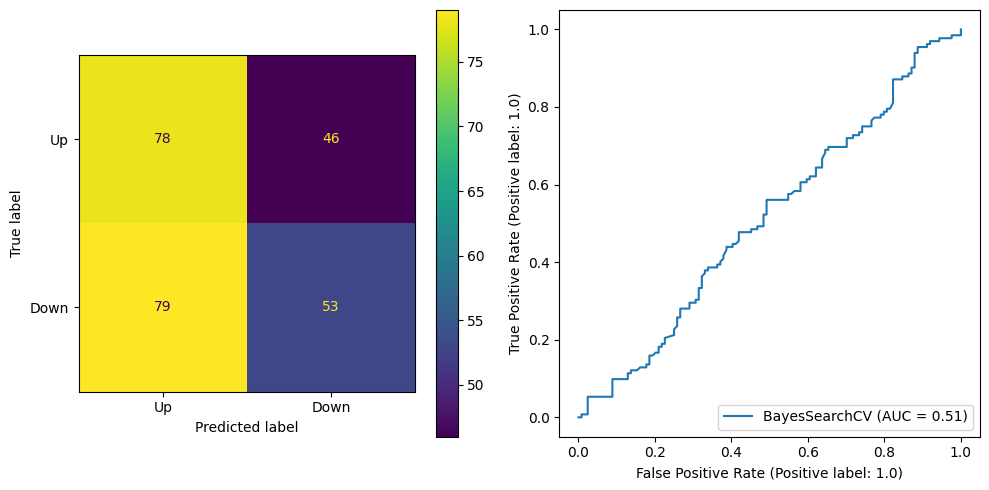

In [76]:
fig, axes = plt.subplots(1,2,figsize=(10,5))
ax = axes.reshape(-1)[0]
ConfusionMatrixDisplay.from_estimator(lr_bs, X_test_w, y_test_w1, display_labels=['Up', 'Down'], ax=ax)
ax = axes.reshape(-1)[1] 
RocCurveDisplay.from_estimator(lr_bs, X_test_w, y_test_w1, ax=ax)
plt.tight_layout()

Vemos que los resultados han mejorado bastante. Parece también, que el modelo se sobre ajusta ligeramente, puesto que la puntiación en el conjunto de entrenamiento es un poco superior a la de test


In [77]:
print(classification_report(lr_bs.predict(X_test_w), y_test_w2, target_names=['Up','Down']))

              precision    recall  f1-score   support

          Up       0.70      0.61      0.65       157
        Down       0.49      0.59      0.53        99

    accuracy                           0.60       256
   macro avg       0.59      0.60      0.59       256
weighted avg       0.62      0.60      0.61       256



El modelo tiene un rendimiento aceptable, especialmente para la clase "Up" donde tiene una precisión y recall más equilibrados.
Sin embargo, para la clase "Down", la precisión es más baja, lo que indica que el modelo tiende a clasificar erróneamente algunas instancias como "Down".
El F1-score equilibrado sugiere que el modelo es capaz de mantener un buen equilibrio entre precisión y recall en general.

Ahora provaremos con una Red Neuronal

In [78]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import cross_val_score, TimeSeriesSplit
from sklearn.metrics import mean_squared_error, make_scorer
param = {'hidden_layer_sizes':[100, 200, 300], 
         'activation':['relu',  'logistic'], 
         'alpha':[0.0001, 0.001, 0.01],
         'momentum': [0.95, 0.90, 0.85], 
         'learning_rate_init': [0.001, 0.01, 0.1],
         'n_iter_no_change':[30, 40, 50], 
         'learning_rate': ['constant', 'invscaling', 'adaptive']}

mlp =  MLPClassifier(max_iter=10000,early_stopping=True,random_state=0)
print(np.mean(cross_val_score(mlp,X_train_w,y_train_w2,cv=10)))

mlp_bs = BayesSearchCV(mlp,param,n_iter=15, 
                        cv=TimeSeriesSplit(n_splits=5, gap=w+1), 
                        scoring=make_scorer(mean_squared_error, greater_is_better=False),
                        n_jobs=-1, 
                        refit=True, random_state=0)    
mlp_bs.fit(X_train_w, y_train_w2)

0.5787979797979798


BayesSearchCV(cv=TimeSeriesSplit(gap=4, max_train_size=None, n_splits=5, test_size=None),
              estimator=MLPClassifier(early_stopping=True, max_iter=10000,
                                      random_state=0),
              n_iter=15, n_jobs=-1, random_state=0,
              scoring=make_scorer(mean_squared_error, greater_is_better=False),
              search_spaces={'activation': ['relu', 'logistic'],
                             'alpha': [0.0001, 0.001, 0.01],
                             'hidden_layer_sizes': [100, 200, 300],
                             'learning_rate': ['constant', 'invscaling',
                                               'adaptive'],
                             'learning_rate_init': [0.001, 0.01, 0.1],
                             'momentum': [0.95, 0.9, 0.85],
                             'n_iter_no_change': [30, 40, 50]})

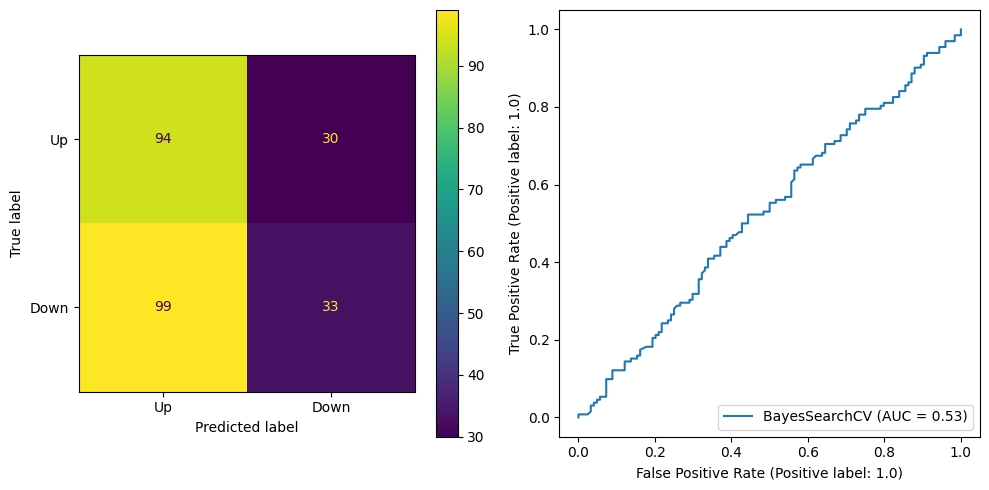

In [79]:
fig, axes = plt.subplots(1,2,figsize=(10,5))
ax = axes.reshape(-1)[0]
ConfusionMatrixDisplay.from_estimator(mlp_bs, X_test_w, y_test_w1, display_labels=['Up', 'Down'], ax=ax)
ax = axes.reshape(-1)[1]
RocCurveDisplay.from_estimator(mlp_bs, X_test_w, y_test_w1, ax=ax)
plt.tight_layout()

In [80]:
print(classification_report(mlp_bs.predict(X_test_w), y_test_w2, target_names=['Up','Down']))

              precision    recall  f1-score   support

          Up       0.80      0.56      0.66       193
        Down       0.29      0.56      0.38        63

    accuracy                           0.56       256
   macro avg       0.54      0.56      0.52       256
weighted avg       0.67      0.56      0.59       256



Como vemos hay mucho mas desequilibrio entre Up y Down. Por lo tanto no podemos decir que este modelo es mejor que la Regresión Lineal.

## Conclusiones

Cómo hemos visto en los experimentos, ninguno de los modelos probados ha resultado demasiado acertado a la hora de predecir ya sea si el precio de la acción será mes alto o si el número de las acciones será mas alto que el día anteriror. Tiene sentido, puesto que la bolsa es un mundo complejo, en el que intervienen muchos factores que no estan reflejados en nuestros datos.  Además si con tanta poca información pudiesemos entrenar un modelo que, consistentemente nos predijera si las acciones de una empresa cotizarán mejor o peor que el día anterior, invertir a la bolsa sería muy sencillo.
